In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis/all-data.csv
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/361.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/245.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/141.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/372.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/333.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/276.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/244.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/175.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/351.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/265.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/178.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/201.txt
/kaggle/input/bbc-news-summary/BBC News Summary/Summar

# News Summary

### Importing necessary libraries and dataset

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
from torch.utils.data import Dataset

2024-08-11 15:32:03.647152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 15:32:03.647256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 15:32:03.783504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define paths
articles_path = '../input/bbc-news-summary/BBC News Summary/News Articles/'
summaries_path = '../input/bbc-news-summary/BBC News Summary/Summaries/'

### Preprocessing the data

In [5]:
# Data Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = text.strip()
    text = text.replace('\n', ' ')
    return text

In [6]:
# Initialize lists to hold articles, summaries, and file paths
articles, summaries, file_paths = [], [], []

In [7]:
# Load articles and summaries
for category in os.listdir(articles_path):
    category_articles_path = os.path.join(articles_path, category)
    category_summaries_path = os.path.join(summaries_path, category)
    
    for filename in os.listdir(category_articles_path):
        article_file = os.path.join(category_articles_path, filename)
        summary_file = os.path.join(category_summaries_path, filename)
        
        try:
            with open(article_file, 'r', encoding='utf-8') as af, open(summary_file, 'r', encoding='utf-8') as sf:
                article = af.read()
                summary = sf.read()
                
                # Apply preprocessing
                article = preprocess_text(article)
                summary = preprocess_text(summary)
                
                articles.append(article)
                summaries.append(summary)
                file_paths.append((article_file, summary_file))
        except Exception as e:
            print(f"Error processing {article_file} and {summary_file}: {e}")

Error processing ../input/bbc-news-summary/BBC News Summary/News Articles/sport/199.txt and ../input/bbc-news-summary/BBC News Summary/Summaries/sport/199.txt: 'utf-8' codec can't decode byte 0xa3 in position 257: invalid start byte


In [8]:
pd.set_option('display.max_colwidth', 200)
df = pd.DataFrame({'path': file_paths, 'article': articles, 'summary': summaries})

df.head()

,path,article,summary
0,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/361.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/361.txt)",budget to set scene for election gordon brown will seek to put the economy at the centre of labour's bid for a third term in power when he delivers his ninth budget at 1230 gmt. he is expected to...,"- increase in the stamp duty threshold from £60,000 - a freeze on petrol duty - an extension of tax credit scheme for poorer families - possible help for pensioners the stamp duty threshold rise i..."
1,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/245.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/245.txt)","army chiefs in regiments decision military chiefs are expected to meet to make a final decision on the future of scotland's army regiments. a committee of the army board, which is made up of the...","""they are very much not for the good and will destroy scotland's regiments by moulding them into a single super regiment which will lead to severe recruitment problems, a loss of local connections..."
2,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/141.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/141.txt)",howard denies split over id cards michael howard has denied his shadow cabinet was split over its decision to back controversial labour plans to introduce id cards. the tory leader said his fron...,"michael howard has denied his shadow cabinet was split over its decision to back controversial labour plans to introduce id cards.mr howard said the police had said id cards could ""help them foil ..."
3,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/372.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/372.txt)",observers to monitor uk election ministers will invite international observers to check the forthcoming uk general election is fairly run. the move comes amid claims the poll could be marred by ...,the report said individual registration should be treated carefully as 12% of voters disappeared from the electoral roll in northern ireland when it was introduced in 2002.odpm committee chairman ...
4,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/333.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/333.txt)",kilroy names election seat target ex-chat show host robert kilroy-silk is to contest the derbyshire seat of erewash at the next general election. labour's elizabeth blackman won the seat in 1997...,"ukip's leader, roger knapman, has said he is glad to see the back of mr kilroy-silk.""he has remarkable ability to influence people but, sadly, after the [european] election it became clear that he..."


In [9]:
#Drop rows with missing values
df = df.dropna(subset=['article', 'summary'])

## Exploratory Data Analysis

In [10]:
# Function to count the number of words in a text
def count_words(text):
    return len(text.split())

df['wordcnt_article'] = df['article'].apply(count_words)
df['wordcnt_summary'] = df['summary'].apply(count_words)
df.head()

,path,article,summary,wordcnt_article,wordcnt_summary
0,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/361.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/361.txt)",budget to set scene for election gordon brown will seek to put the economy at the centre of labour's bid for a third term in power when he delivers his ninth budget at 1230 gmt. he is expected to...,"- increase in the stamp duty threshold from £60,000 - a freeze on petrol duty - an extension of tax credit scheme for poorer families - possible help for pensioners the stamp duty threshold rise i...",538,192
1,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/245.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/245.txt)","army chiefs in regiments decision military chiefs are expected to meet to make a final decision on the future of scotland's army regiments. a committee of the army board, which is made up of the...","""they are very much not for the good and will destroy scotland's regiments by moulding them into a single super regiment which will lead to severe recruitment problems, a loss of local connections...",500,266
2,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/141.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/141.txt)",howard denies split over id cards michael howard has denied his shadow cabinet was split over its decision to back controversial labour plans to introduce id cards. the tory leader said his fron...,"michael howard has denied his shadow cabinet was split over its decision to back controversial labour plans to introduce id cards.mr howard said the police had said id cards could ""help them foil ...",540,225
3,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/372.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/372.txt)",observers to monitor uk election ministers will invite international observers to check the forthcoming uk general election is fairly run. the move comes amid claims the poll could be marred by ...,the report said individual registration should be treated carefully as 12% of voters disappeared from the electoral roll in northern ireland when it was introduced in 2002.odpm committee chairman ...,496,223
4,"(../input/bbc-news-summary/BBC News Summary/News Articles/politics/333.txt, ../input/bbc-news-summary/BBC News Summary/Summaries/politics/333.txt)",kilroy names election seat target ex-chat show host robert kilroy-silk is to contest the derbyshire seat of erewash at the next general election. labour's elizabeth blackman won the seat in 1997...,"ukip's leader, roger knapman, has said he is glad to see the back of mr kilroy-silk.""he has remarkable ability to influence people but, sadly, after the [european] election it became clear that he...",440,185


In [11]:
article_lengths = [len(article.split()) for article in articles]
summary_lengths = [len(summary.split()) for summary in summaries]

print(f'Number of articles: {len(articles)}')
print(f'Number of summaries: {len(summaries)}')
print(f'Average article length (words): {np.mean(article_lengths):.2f}')
print(f'Average summary length (words): {np.mean(summary_lengths):.2f}')

Number of articles: 2224
Number of summaries: 2224
Average article length (words): 384.01
Average summary length (words): 165.15


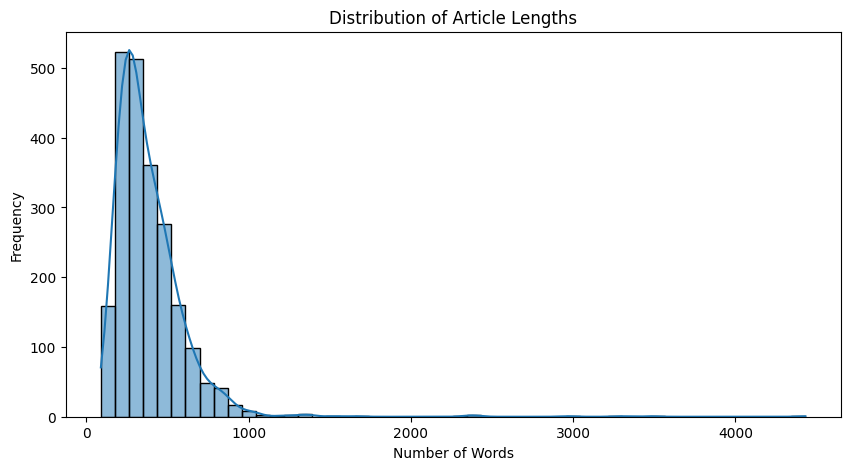

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualize article lengths
plt.figure(figsize=(10, 5))
sns.histplot(article_lengths, bins=50, kde=True)
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

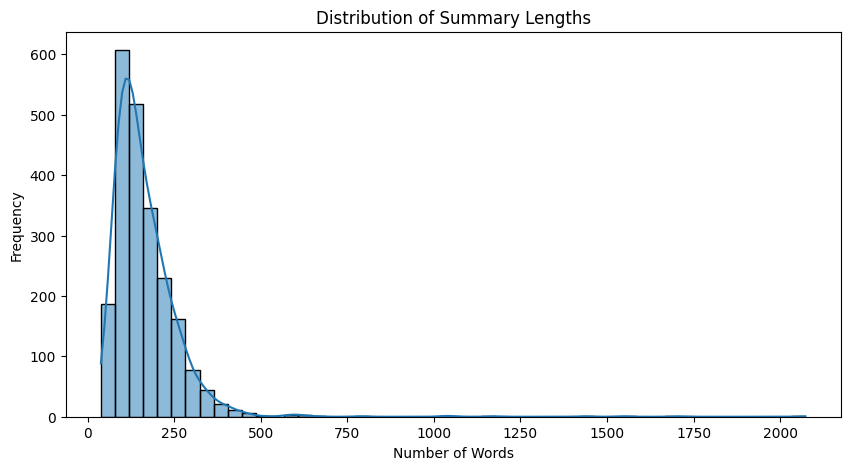

In [13]:
# Visualize summary lengths
plt.figure(figsize=(10, 5))
sns.histplot(summary_lengths, bins=50, kde=True)
plt.title('Distribution of Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

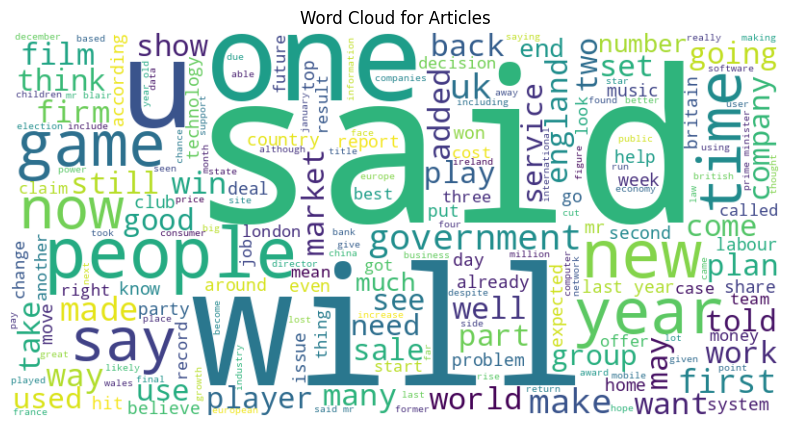

In [14]:
from wordcloud import WordCloud
# Word Cloud for Articles
all_articles = ' '.join(articles)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_articles)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Articles')
plt.show()

In [15]:
df.describe()

,wordcnt_article,wordcnt_summary
count,2224.000000,2224.000000
mean,384.013939,165.151529
std,238.224778,108.678038
min,89.000000,38.000000
25%,245.750000,103.000000
50%,332.000000,142.000000
75%,471.000000,202.000000
max,4432.000000,2073.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             2224 non-null   object
 1   article          2224 non-null   object
 2   summary          2224 non-null   object
 3   wordcnt_article  2224 non-null   int64 
 4   wordcnt_summary  2224 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 87.0+ KB


### Tokenizing

In [17]:
# Tokenize and encode the articles and summaries
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
df['article_encodings'] = df['article'].apply(lambda x: tokenizer.encode(x, return_tensors='pt', max_length=1024, truncation=True))
df['summary_encodings'] = df['summary'].apply(lambda x: tokenizer.encode(x, return_tensors='pt', max_length=512, truncation=True))

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

In [18]:
class SummarizationDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        article_encoding = self.data.iloc[idx]['article_encodings'].squeeze(0)
        summary_encoding = self.data.iloc[idx]['summary_encodings'].squeeze(0)
        return {'input_ids': article_encoding, 'labels': summary_encoding}

In [19]:
train_dataset = SummarizationDataset(train_df)
val_dataset = SummarizationDataset(val_df)

### Importing the facebook/bart-large-cnn model

In [20]:
# Define the model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_l

### Training

In [21]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    fp16=True,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch"
)

In [22]:
# Initialize the data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)

In [23]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
0,0.217300,0.168591
1,0.092300,0.131634
2,0.063300,0.125446


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=1500, training_loss=0.1338133415778478, metrics={'train_runtime': 1504.8583, 'train_samples_per_second': 3.989, 'train_steps_per_second': 0.997, 'total_flos': 6230590803492864.0, 'train_loss': 0.1338133415778478, 'epoch': 2.9985007496251876})

### Evaluating the model

In [24]:
# Evaluate the model
results = trainer.evaluate()

In [25]:
# Print evaluation results
print(results)

{'eval_loss': 0.12544581294059753, 'eval_runtime': 16.539, 'eval_samples_per_second': 13.483, 'eval_steps_per_second': 13.483, 'epoch': 2.9985007496251876}


In [27]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=610c3ad2f7ec554ba9689438f756d15667f5cbebd1e540b993f270dc9a47fd52
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [28]:
from datasets import load_metric

# Define ROUGE metric
rouge = load_metric("rouge")

def evaluate_model(dataset):
    model.eval()
    predictions, references = [], []
    
    for item in dataset:
        inputs = {'input_ids': item['input_ids'].unsqueeze(0).to(device)}
        summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
        prediction = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        predictions.append(prediction)
        
        reference = tokenizer.decode(item['labels'], skip_special_tokens=True)
        references.append(reference)
    
    rouge_results = rouge.compute(predictions=predictions, references=references)
    return rouge_results

The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [29]:
# Evaluate the model
rouge_results = evaluate_model(val_dataset)

rouge_df = pd.DataFrame(rouge_results)
print(rouge_df)

                                                         rouge1  \
0  (0.8382230498309823, 0.5968141029704944, 0.6795447749985508)   
1  (0.8554159685151134, 0.6205739106002235, 0.6973490564337717)   
2  (0.8718091530264551, 0.6469150491471214, 0.7164570411239068)   

                                                         rouge2  \
0  (0.7597665728512113, 0.5408060012708776, 0.6164901984158057)   
1   (0.780346667184654, 0.5659958011253905, 0.6356516587219601)   
2  (0.7999666737325524, 0.5890516017357167, 0.6545887368211243)   

                                                          rougeL  \
0   (0.6401844934798615, 0.4581356879682586, 0.5201736853477136)   
1  (0.6590096869644129, 0.48084877186029323, 0.5393811532641172)   
2    (0.6790423352419536, 0.504263716997295, 0.5587568677798851)   

                                                       rougeLsum  
0  (0.6400721078265549, 0.45976985205659143, 0.5218737295669509)  
1    (0.6586262354569015, 0.4826188820982653, 0.5399905

In [30]:
# Or save the entire model
torch.save(model, 'news_summary.pth')

# Sentiment Analysis

## LSTM Model

### Importing the libraries and dataset

In [27]:
# Import libraries from Shatakshi model
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# Load data file
df = pd.read_csv('/kaggle/input/sentiment-analysis/all-data.csv',delimiter=',',encoding='latin-1')

In [29]:
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'Message'})

### Visualization

In [30]:
df.head()

,sentiment,Message
0,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
1,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...
2,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profi...
3,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net ..."
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .


In [31]:
df.index = range(4845)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111964

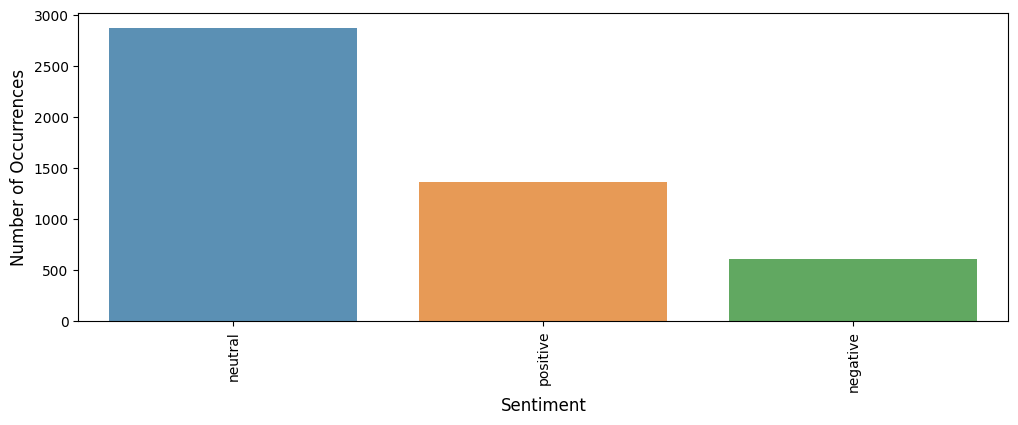

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

cnt_pro = df['sentiment'].value_counts()

plt.figure(figsize=(12, 4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)  # Use keyword arguments
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show()


### Data preprocessing

In [33]:
#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

df.sentiment = [sentiment[item] for item in df.sentiment] 
print(df)

      sentiment  \
0             1   
1             2   
2             0   
3             0   
4             0   
...         ...   
4840          2   
4841          1   
4842          2   
4843          2   
4844          2   

                                                                                                                                                                                                      Message  
0              Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .  
1     The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers ...  
2     With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of ra

In [34]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .
Message: 0


In [35]:
print_message(0)

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
Message: 1


In [36]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

In [37]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4845 unique tokens.


### Training

In [38]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


In [39]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', "''", 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

In [40]:
from gensim.models import Doc2Vec
from tqdm import tqdm

d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4844/4844 [00:00<00:00, 1474933.47it/s]


In [41]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 1408081.54it/s]


CPU times: user 11.5 s, sys: 56.2 ms, total: 11.6 s
Wall time: 11.5 s


In [42]:
print(d2v_model)

Doc2Vec<dm/m,d20,n5,w8,s0.001>


In [43]:
vocab_size = len(d2v_model.wv.key_to_index)
print(vocab_size)

11683


In [44]:
import numpy as np

# Create an embedding matrix with the correct shape
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))

# Iterate over the document vectors and populate the embedding matrix
for i, vec in enumerate(d2v_model.dv.vectors):
    if i <= 1000:  # Limit to the first 1000 vectors, if that's the intent
        embedding_matrix[i] = vec

In [45]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('loss', 0.8842743039131165),
 ('income', 0.8092931509017944),
 ('statements', 0.8007365465164185),
 ('pcmag.com', 0.7636975646018982),
 ('profits', 0.7615823149681091),
 ('walby', 0.7564753293991089),
 ('chopra', 0.7519423961639404),
 ('sales', 0.7504588961601257),
 ('larger-than-epected', 0.7360278964042664),
 ('mistake', 0.7340577244758606)]

In [46]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('organization', 0.7987059950828552),
 ('property', 0.7481488585472107),
 ('8,000', 0.7265296578407288),
 ('fund', 0.7205101847648621),
 ('estate', 0.7010034322738647),
 ('sellers', 0.70018470287323),
 ('zapadnye', 0.6995275020599365),
 ('placed', 0.6943881511688232),
 ('value', 0.6939641237258911),
 ('let', 0.6937140226364136)]

In [47]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9275333285331726),
 ('seitovirta', 0.8653897047042847),
 ('elaborated', 0.8605459332466125),
 ('mika', 0.84832364320755),
 ('bibs', 0.832392692565918),
 ('baby', 0.8232241272926331),
 ('usko', 0.8213926553726196),
 ('cagr', 0.8152110576629639),
 ('quipped', 0.8147236108779907),
 ('katzman', 0.8129352331161499)]

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in d2v_model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import tensorflow as tf

# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(
    input_dim=len(d2v_model.wv.key_to_index) + 1,  # Updated line
    output_dim=20,
    input_length=X.shape[1],
    weights=[embedding_matrix],
    trainable=True
))

# learn the correlations
def split_input(sequence):
    return sequence[:-1], tf.reshape(sequence[1:], (-1, 1))

model.add(LSTM(50, return_sequences=False))
model.add(Dense(3, activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       233,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,680 (912.81 KB)

 Trainable params: 233,680 (912.81 KB)

 Non-trainable params: 0 (0.00 B)

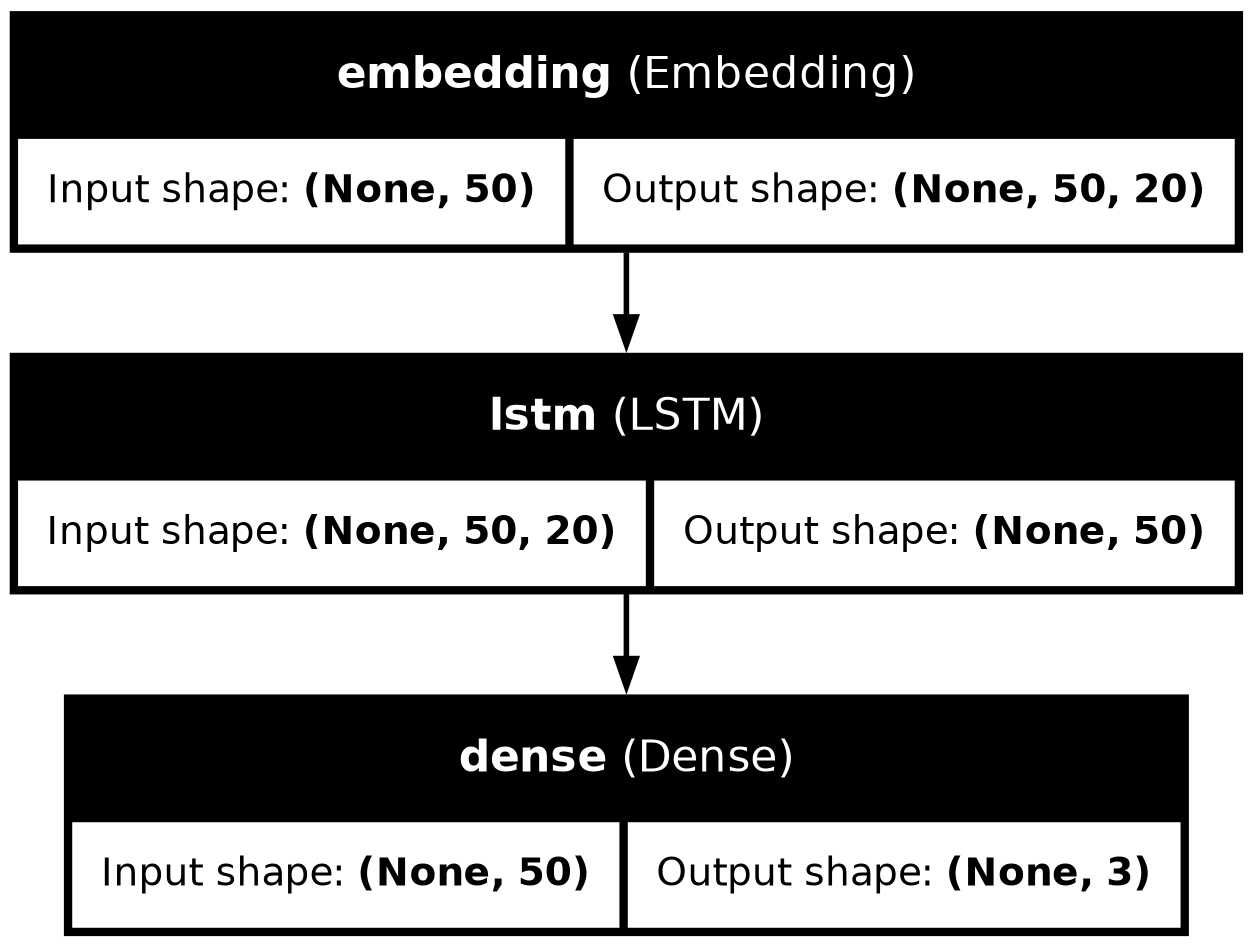

In [50]:
# Build the model by specifying the input shape
model.build(input_shape=(None, X.shape[1]))

# Now you can plot the model
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [51]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [52]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 4s - 30ms/step - acc: 0.5928 - loss: 0.5539
Epoch 2/50
129/129 - 1s - 5ms/step - acc: 0.6474 - loss: 0.4868
Epoch 3/50
129/129 - 1s - 5ms/step - acc: 0.7455 - loss: 0.3655
Epoch 4/50
129/129 - 1s - 5ms/step - acc: 0.8116 - loss: 0.2705
Epoch 5/50
129/129 - 1s - 5ms/step - acc: 0.8691 - loss: 0.2072
Epoch 6/50
129/129 - 1s - 5ms/step - acc: 0.9301 - loss: 0.1379
Epoch 7/50
129/129 - 1s - 5ms/step - acc: 0.9495 - loss: 0.1043
Epoch 8/50
129/129 - 1s - 5ms/step - acc: 0.9755 - loss: 0.0597
Epoch 9/50
129/129 - 1s - 5ms/step - acc: 0.9798 - loss: 0.0463
Epoch 10/50
129/129 - 1s - 5ms/step - acc: 0.9847 - loss: 0.0396
Epoch 11/50
129/129 - 1s - 5ms/step - acc: 0.9891 - loss: 0.0307
Epoch 12/50
129/129 - 1s - 5ms/step - acc: 0.9913 - loss: 0.0238
Epoch 13/50
129/129 - 1s - 5ms/step - acc: 0.9908 - loss: 0.0246
Epoch 14/50
129/129 - 1s - 5ms/step - acc: 0.9905 - loss: 0.0227
Epoch 15/50
129/129 - 1s - 5ms/step - acc: 0.9932 - loss: 0.0199
Epoch 16/50
129/129 - 1s - 5ms/st

### Model Evaluation

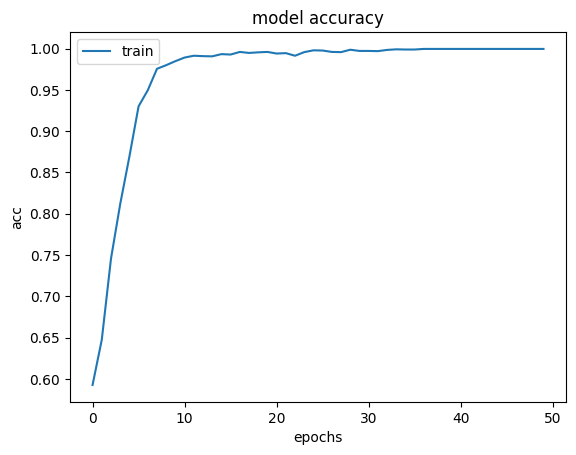

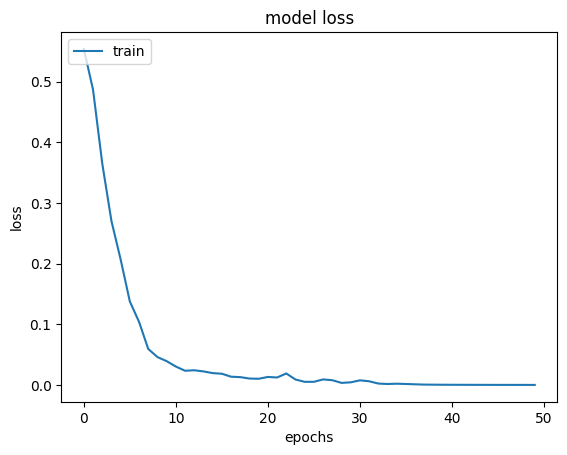

<Figure size 640x480 with 0 Axes>

In [53]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [54]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - 4ms/step - acc: 0.9998 - loss: 3.3974e-04
23/23 - 0s - 3ms/step - acc: 0.7056 - loss: 1.6120
Train: 1.000, Test: 0.7056


In [55]:
import numpy as np

# Predict probabilities for the test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)

# Predict crisp classes for the test set
yhat_classes = np.argmax(yhat_probs, axis=1)
print(yhat_classes)

[[3.8947345e-10 1.0000000e+00 1.3510100e-10]
 [1.0000000e+00 9.7539932e-09 8.5660723e-09]
 [2.0610607e-06 9.9999726e-01 7.4280803e-07]
 ...
 [1.0000000e+00 2.4467084e-10 6.8004385e-10]
 [2.7174180e-10 1.0000000e+00 1.3217040e-10]
 [1.0000000e+00 2.7588162e-10 5.7674188e-10]]
[1 0 1 0 1 1 1 1 1 1 1 1 0 2 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 2 1 1 1 2 1 1 2
 0 1 1 1 1 2 1 0 1 1 1 0 1 2 1 0 2 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1
 0 1 1 1 1 0 1 2 0 1 0 0 1 0 1 0 0 1 1 2 1 1 0 1 0 1 0 1 1 2 1 1 2 1 2 1 1
 1 0 0 1 0 1 0 2 0 0 0 0 1 1 1 1 1 1 1 1 0 2 1 0 1 0 2 1 0 1 1 1 1 1 1 2 1
 0 1 1 1 1 1 1 0 0 1 2 1 1 1 1 0 1 0 1 2 1 0 1 0 0 1 0 2 0 0 1 0 1 0 0 1 1
 2 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 2 0 0 0 1
 1 0 1 1 1 0 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1
 1 0 0 1 0 2 2 2 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 2 2 1 2 1
 1 2 0 1 0 1 1 1 1 0 1 0 1 0 1 2 1 1 1 1 1 1 1 0 1 2 0 1 0 1 1 1 1 1 1 1 1
 1 0 2 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0 2 1 1 0 

In [56]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[131,  79,   5],
       [ 73, 339,  14],
       [ 17,  26,  43]])

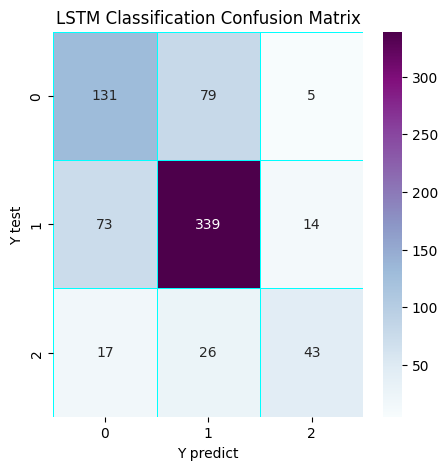

In [58]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

### Validation

In [59]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7375 - loss: 1.5636 
score: 1.58
acc: 0.73


In [65]:
torch.save(model, 'sentiment_analysis_LSTM.pth')

# Results

## Summarization

In [26]:
# Function to generate summary
def generate_summary(article):
    inputs = tokenizer.encode("summarize: " + article, return_tensors='pt', max_length=1024, truncation=True).to(device)
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Generate summary for a new article
new_article = "Ad sales boost Time Warner profit Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier. The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding. Time Warner's fourth quarter profits were slightly better than analysts' expectations. But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results. For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn. 'Our financial performance was strong, meeting or exceeding all of our full-year objectives and greatly enhancing our flexibility,' chairman and chief executive Richard Parsons said. For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins. TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators. It has already offered to pay $300m to settle charges, in a deal that is under review by the SEC. The company said it was unable to estimate the amount it needed to set aside for legal reserves, which it previously set at $500m. It intends to adjust the way it accounts for a deal with German music publisher Bertelsmann's purchase of a stake in AOL Europe, which it had reported as advertising revenue. It will now book the sale of its stake in AOL Europe as a loss on the value of that stake."
summary = generate_summary(new_article)
print(summary)

timeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.for the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4%to $42.09bn.it lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.quarterly profits at US mediathe company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.but its own internet business, AOL


## Sentiment Analysis

In [60]:

message = ["timeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.for the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4%to $42.09bn.it lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.quarterly profits at US mediathe company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues.its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.but its own internet business, AOL"]
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[1.0000000e+00 2.1835493e-09 7.0461470e-10]] 0


## The Summarized news is positive and the sentiment analysis predicts the same